# Module 1: OOK Message Generation

## Import Libraries
This is originally created on in GNURadio Companion (GRC), which then generates a python executable file, which I am transfering to this notebook.

In [1]:
from gnuradio import analog
from gnuradio import blocks
from gnuradio import eng_notation
from gnuradio import gr
from gnuradio.eng_option import eng_option
from gnuradio.filter import firdes
from optparse import OptionParser
import time
import os

## Create the main flowgraph
This "main_flow" is also known as the "top_block" in most GNURadio flowgraphs. It contains the essential elements of the radio, and all the functionality of the flowgraph.

In [2]:
main_flow = gr.top_block("MOD_1_OOK_Message_Generator")  

## Declare and Define the Variables

### samp_rate will usually be the 8 Million samples per second for HackRF devices

In [3]:
main_flow.samp_rate = samp_rate = 8e6
samp_rate

8000000.0

### short_pulse is the length in microsconds of the shortest pulse

In [4]:
main_flow.short_pulse = short_pulse = 250

### offset will be how far off the center frequency this will generate. 
    * This is necessary because there is often device generated interference 
      at the center frequency. 
    * Making it a negative means it will be below the center frequency

In [5]:
main_flow.offset = offset = -samp_rate/4
offset

-2000000.0

### the generated signal will save into a descriptive file that contains the sample rate in millions --- which is essential for proper Tx and Rx
* '.iq' indicates it contains complex data type -- which will be imported using complex64

In [6]:
main_flow.filename = filename = "GDO_Generated_" + str((samp_rate/1e6)) + ".iq"
# make it absolute
filename = os.getcwd() + '/' + filename
filename

'/home/jon/pinode_notes/working/GDO_Generated_8.0.iq'

### message preamble and body content in short_pulses

In [7]:
main_flow.message_preamble = message_preamble = (1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
main_flow.message_content = message_body =  (1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
message_preamble+message_body;

## Create the Blocks

In [8]:
main_flow.vector_source = blocks.vector_source_f(message_preamble+message_body, True, 1, [])  # Repeat source = True?
main_flow.throttle = blocks.throttle(gr.sizeof_gr_complex*1, samp_rate,True)                  # Necessary to regulate processing
main_flow.repeat = blocks.repeat(gr.sizeof_float*1, int(short_pulse*(samp_rate/1e6)))         # Interpolation, to make sample rate related to microsecond short_pulse
main_flow.multiply = blocks.multiply_vcc(1)                                                   # A kind of amplification
main_flow.float_to_complex = blocks.float_to_complex(1)                                       # takes two inputs to make a complex number
main_flow.file_sink = blocks.file_sink(gr.sizeof_gr_complex*1, filename, False)
main_flow.file_sink.set_unbuffered(False)
main_flow.analog_sig_source = analog.sig_source_c(samp_rate, analog.GR_COS_WAVE, offset, 1, 0)
main_flow.analog_const_source = analog.sig_source_f(0, analog.GR_CONST_WAVE, 0, 0, 0)

## Connect the Blocks

In [9]:
main_flow.connect((main_flow.analog_const_source, 0), (main_flow.float_to_complex, 1))
main_flow.connect((main_flow.analog_sig_source, 0), (main_flow.multiply, 1))
main_flow.connect((main_flow.float_to_complex, 0), (main_flow.multiply, 0))
main_flow.connect((main_flow.multiply, 0), (main_flow.throttle, 0))
main_flow.connect((main_flow.repeat, 0), (main_flow.float_to_complex, 0))
main_flow.connect((main_flow.throttle, 0), (main_flow.file_sink, 0))
main_flow.connect((main_flow.vector_source, 0), (main_flow.repeat, 0))

## Define Utility Definitions

In [10]:
def get_samp_rate():
    return main_flow.samp_rate

def set_samp_rate(samp_rate):
    main_flow.samp_rate = samp_rate
    main_flow.set_offset(-main_flow.samp_rate/4)
    main_flow.throttle.set_sample_rate(main_flow.samp_rate)
    main_flow.repeat.set_interpolation(int(main_flow.short_pulse*(main_flow.samp_rate/1e6)))
    main_flow.analog_sig_source.set_sampling_freq(main_flow.samp_rate)

def get_short_pulse():
    return main_flow.short_pulse

def set_short_pulse(short_pulse):
    main_flow.short_pulse = short_pulse
    main_flow.repeat.set_interpolation(int(main_flow.short_pulse*(main_flow.samp_rate/1e6)))

def get_offset():
    return main_flow.offset

def set_offset(offset):
    main_flow.offset = offset
    main_flow.analog_sig_source.set_frequency(main_flow.offset)

def get_filename():
    return main_flow.filename

def set_filename(filename):
    main_flow.filename = filename
    main_flow.file_sink.open(main_flow.filename)

## Define the main function

In [11]:
def main():
    start_time = time.time()
    keep_going = True
    # time in seconds to run this
    how_long = 1
    main_flow.start()
    try:
        while keep_going:
            end_time = time.time()
            if (end_time-start_time) > how_long:
                keep_going = False
    except EOFError:
        pass
    main_flow.stop()
    main_flow.wait()

In [12]:
main()

In [13]:
main_flow.stop()
main_flow.wait()

In [18]:
!ls -lh $filename
%store filename



-rw-r--r-- 1 jon jon 61M Sep 24 14:46 /home/jon/pinode_notes/working/GDO_Generated_8.0.iq
Stored 'filename' (str)


# Conclusion
This notebook ends after having generated a file that can then be taken and analyzed seperately or transmitted with an SDR device

In [15]:
import numpy as np
dat = np.fromfile(filename, dtype="complex64")

/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:7674: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


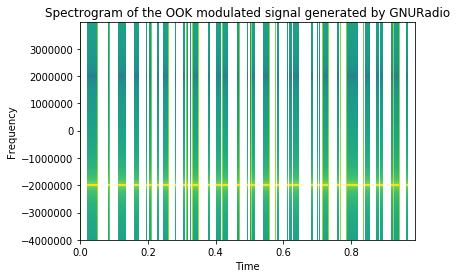

In [19]:
import matplotlib.pyplot as plt
center_freq = 0
# plt.figure(figsize=(20, 4))
plt.specgram(dat, NFFT=int(1024/4), Fs=samp_rate, Fc=center_freq) #,pad_to=1000
plt.title("Spectrogram of the OOK modulated signal generated by GNURadio")
plt.xlabel("Time")
plt.ylabel("Frequency")
# plt.savefig("MOD_1_OOK_signal_spectrogram.pdf", bbox_inches='tight', pad_inches=0.5) 
plt.show()

In [17]:
%store filename

Stored 'filename' (str)
